In [296]:
import pickle as pkl
import numpy as np
from celluloid import Camera
import pdb
import scipy
import ipdb
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from scipy.spatial.transform import Rotation as R
from matplotlib.patches import Rectangle
from IPython.display import HTML
import cv2

In [323]:
def get_angle2(pos1, pos2):
    dx = pos1[0] - pos2[0]
    dy = pos1[2] - pos2[2]
    return 180./math.pi * np.arctan2(dy, dx)

def get_angle(rot):
    rot = R.from_quat(rot)
    euler = rot.as_euler('xzy')
    # dchange = np.sin(euler[1])*np.cos(euler[0]), np.cos(euler[1])*np.sin(euler[0])
    # dchange = np.sin(euler[1]+euler[0]), np.cos(euler[1]+euler[0])
    x = np.cos(euler[2])*np.cos(euler[1])
    y = np.sin(euler[2])*np.cos(euler[1])
    z = np.sin(euler[1])
    dchange = y, x
    return np.arctan2(x,y)*180 / math.pi
    
def plot_graph_2d(graph, ax, goal_ids, belief_ids=[], c_obs_ids=None):


    #nodes_interest = [node for node in graph['nodes'] if 'GRABBABLE' in node['properties']]
    goals = [node for node in graph['nodes'] if node['class_name'] in goal_ids]
    
    belief_obj = [node for node in graph['nodes'] if node['id'] in belief_ids]

    # container_surf = dict_info['objects_inside'] + dict_info['objects_surface']
#     pdb.set_trace()
    container_surf = ['kitchentable', 'cabinet', 'kitchencabinet', 'kitchencabinets', 'fridge', 'bathroomcabinet', 'stove', 'coffeetable', 'dishwasher']
    container_and_surface = [node for node in graph['nodes'] if node['class_name'] in container_surf]
    container_open = [node for node in graph['nodes'] if node['class_name'] in container_surf and 'OPEN' in node['states']]
    container_open_id = [n['id'] for n in container_open]
    c_obs_ids = [c for c in c_obs_ids if c not in container_open_id]
    obs_objects = [node for node in graph['nodes'] if node['id'] in c_obs_ids and node['category'] not in ['Rooms', 'Doors'] and node['class_name'] != 'character']
    
    
    node_char = [node for node in graph['nodes'] if node['id'] == 1][0]
#     for ob in obs_objects:
#         pos_char = node_char['obj_transform']['position']
#         angle_char = get_angle(node_char['obj_transform']['rotation'])
#         print(ob['class_name'], get_angle2(ob['obj_transform']['position'], pos_char), angle_char)
    
    #grabbed_obj = [node for node in graph['nodes'] if node['class_name'] in dict_info['objects_grab']]
    rooms = [node for node in graph['nodes'] if 'Rooms' == node['category']]


    # containers and surfaces
    # visible_nodes = [node for node in graph['nodes'] if node['id'] in visible_ids and node['category'] != 'Rooms']
    # action_nodes = [node for node in graph['nodes'] if node['id'] in action_ids and node['category'] != 'Rooms']

    # goal_nodes = [node for node in graph['nodes'] if node['class_name'] == 'cupcake']

    # Character
    # char_node = [node for node in graph['nodes'] if node['id'] == char_id][0]

    
    add_boxes(rooms, ax, points=None, rect={'alpha': 0.1})
    
        
    if len(container_and_surface) > 0:
        add_boxes(container_and_surface, ax, points=None, rect={'fill': False, 'edgecolor': 'blue', 'alpha': 0.3})
        
    if len(container_open) > 0:
#         print("HERE")
        add_boxes(container_open, ax, points=None, rect={'fill': False, 'edgecolor': 'orange', 'alpha': 1.0})
        
    #add_boxes([char_node], ax, points=None, rect={'facecolor': 'yellow', 'edgecolor': 'yellow', 'alpha': 0.7})
    #add_boxes(visible_nodes, ax, points={'s': 2.0, 'alpha': 1.0}, rect={'fill': False,
    #                     
    
    #add_boxes(action_nodes, ax, points={'s': 3.0, 'alpha': 1.0, 'c': 'red'})


    #bad_classes = ['character']
    if len(obs_objects):
        add_boxes(obs_objects, ax, points=None, rect={'fill': False, 'edgecolor': 'green', 'alpha': 0.5})
    
    if len(goals) > 0:
        add_boxes(goals, ax, points={'s':  40.0, 'alpha': 1.0, 'edgecolors': 'magenta', 'facecolors': 'none', 'linewidth': 1.0})
    if len(belief_obj) > 0:
        add_boxes(belief_obj, ax, points={'s':  30.0, 'alpha': 1.0, 'edgecolors': 'blue', 'facecolors': 'none', 'linewidth': 1.0})
    
    ax.set_aspect('equal')
    bx, by = get_bounds([room['bounding_box'] for room in rooms])

    maxsize = max(bx[1] - bx[0], by[1] - by[0])
    gapx = (maxsize - (bx[1] - bx[0])) / 4.
    gapy = (maxsize - (by[1] - by[0])) / 4.

    ax.set_xlim(bx[0]-gapx, bx[1]+gapx)
    ax.set_ylim(by[0]-gapy, by[1]+gapy)
    ax.apply_aspect()
    
def add_box(nodes, args_rect):
    rectangles = []
    centers = [[], []]
    for node in nodes:
        cx, cy = node['bounding_box']['center'][0], node['bounding_box']['center'][2]
        w, h = node['bounding_box']['size'][0], node['bounding_box']['size'][2]
        minx, miny = cx - w / 2., cy - h / 2.
        centers[0].append(cx)
        centers[1].append(cy)
        if args_rect is not None:
            rectangles.append(
                Rectangle((minx, miny), w, h, **args_rect)
            )
    return rectangles, centers


def add_boxes(nodes, ax, points=None, rect=None):
    rectangles = []
    rectangles_class, center = add_box(nodes, rect)
    rectangles += rectangles_class
    if points is not None:
        ax.scatter(center[0], center[1], **points)
    if rect is not None:
        ax.add_patch(rectangles[0])
        collection = PatchCollection(rectangles, match_original=True)
        ax.add_collection(collection)
        
def get_bounds(bounds):
    minx, maxx = None, Non
    miny, maxy = None, None
    for bound in bounds:
        bgx, sx = bound['center'][0] + bound['size'][0] / 2., bound['center'][0] - bound['size'][0] / 2.
        bgy, sy = bound['center'][2] + bound['size'][2] / 2., bound['center'][2] - bound['size'][2] / 2.
        minx = sx if minx is None else min(minx, sx)
        miny = sy if miny is None else min(miny, sy)
        maxx = bgx if maxx is None else max(maxx, bgx)
        maxy = bgy if maxy is None else max(maxy, bgy)
    return (minx, maxx), (miny, maxy)

In [418]:
def visualize_trajectory(file_path=None, gen_vid=False, plot_belief=False, belief_id=None, 
                         full_obs=False, plot_img=False, frame_end=-1, plot_special_actions=False):
    char_id = 1
    if belief_id is None:
        plot_belief = False
    with open(file_path, 'rb') as f:
        content = pkl.load(f)
    
    goal_objs = [x.split('_')[1] for x,y in content['goals'][0].items() if y > 0]
    obs_ids = content['obs']
    
    
    observations = content['graph']
    if 'obj_transform' in observations[0]['nodes'][0]:
#         ipdb.set_trace()
        coords = [[node['obj_transform'] for node in obs['nodes'] if node['id'] == char_id][0] for obs in observations]
        rots = [get_angle(coord['rotation']) for coord in coords]
        xy = np.array([[coord['position'][0],coord['position'][2]] for coord in coords])
    else:
        coords = [[node['bounding_box'] for node in obs['nodes'] if node['id'] == char_id][0] for obs in observations]
        rots = None
        xy = np.array([[coord['center'][0],coord['center'][2]] for coord in coords])
        
    n = 150
    colors = plt.cm.jet(np.linspace(0,1,n))
    if plot_img:
        fig = plt.figure(figsize=(12,6))
#         fig, axes = plt.subplots(2)
#         ax = axes[0]
#         ax_img = axes[1]
        grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.1)
        
        ax = fig.add_subplot(grid[:, :2])
        ax.axis('off')
        ax_img = fig.add_subplot(grid[1, 2])
        ax_img.axis('off')

        
    elif not plot_belief:
        fig = plt.figure(figsize=(12,9))
        ax = plt.axes()
        plt.axis('off')
    else:
        fig = plt.figure(figsize=(12,6))
        grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.1)
        id_object = belief_id
        if False:
            try:
                #pass
                id_object = int(content['subgoals'][0][-1][0].split('_')[1])
            except:
                #pass
                # ipdb.set_trace()
                id_object = int(content['subgoals'][0][0][-1].split('_')[1])
        ax = fig.add_subplot(grid[:, :2])
        ax.axis('off')
        ax_belief = fig.add_subplot(grid[1, 2])
        id2name = {node['id']: node['class_name'] for node in content['init_unity_graph']['nodes']}
    
    if gen_vid:
        camera = Camera(fig)
    steps = len(xy)
    steps_total = list(range(len(xy)))
#     steps_total = steps_total[-10:]
    if not gen_vid:
        steps_total = [len(xy)-1]
        if frame_end != -1:
            steps_total = [frame_end]
        
    if plot_img:
        steps_total[-1] = steps_total[-1] - 1
    
    print(steps_total)
    for steps_t in tqdm(steps_total):
        if plot_img:
            folder = file_path.replace('/logs_episode', '/img/logs_episode').replace('.pik', '/')
            img_path = folder + 'img_{:04d}.png'.format(steps_t)
#             print(img_path)
            img_tensor = cv2.imread(img_path)[:, :, ::-1]
#             print(img_tensor.shape)
            ax_img.imshow(img_tensor)
        if obs_ids is not None:
            try:
                c_obs_ids = obs_ids[steps_t]
            except:
                c_obs_ids = obs_ids[-1]
        if belief_id is None:
            belief_ids = []
        else:
            belief_ids = [belief_id]
        plot_graph_2d({'nodes': observations[steps_t]['nodes']}, ax, goal_objs, belief_ids, c_obs_ids)
        if plot_belief:
            belief_object = content['belief'][0][steps_t]
            do_plot_belief(belief_object, id2name, id_object, ax_belief)
        
        its = steps_t
        
#         ax.scatter(cxy[:,0], cxy[:, 1], color=colors[its], s=50, marker= (3, 0, 270+angle))
        
        for steps in range(steps_t+1):
            it = steps

            if it > 0:
                cxy = xy[it-1:it+1,:]
                ax.plot(cxy[:,0], cxy[:, 1], '--', color=colors[min(it, len(colors)-1)], )
                if not gen_vid:
                    ax.plot(cxy[-1:,0], cxy[-1:, 1], '.', color=colors[min(it, len(colors)-1)], )
                

        if plot_special_actions:
            steps_grab = [ls for ls in range(steps_t) if 'grab' in content['action'][0][ls]]
            steps_open = [ls for ls in range(steps_t) if 'open' in content['action'][0][ls]]
            # Grab actions
            ax.plot(xy[steps_grab,0], xy[steps_grab, 1], '*', color='limegreen', )
            # Put actions
            ax.plot(xy[steps_open,0], xy[steps_open, 1], 'p', color='y', )
        
        
        cxy = xy[its:its+1,:]
        if rots is not None:
            angle = rots[its]
            ax.scatter(cxy[:,0]+0.3*np.cos(angle*np.pi/180.), cxy[:, 1]+0.3*np.sin(angle*np.pi/180), color='red', s=15)

        else:
            angle = 0
        
        ax.scatter(cxy[:,0], cxy[:, 1], color='cyan', s=50)

        if gen_vid:
            camera.snap()
    if gen_vid:
        if '/' in file_path:
            dir_name, fname = file_path.split('/')[-2:]
        else:
            dir_name, fname = '', file_path
        fname = fname.replace('.pik', '')
        
        fn = '{}_{}.mp4'.format(dir_name, fname)
        print(fn)
        final = camera.animate()
        final.save(fn)
        return final
    return None

def do_plot_belief(belief_object, id2name, id_object, currax):
#     currax.clear()
    belief_curr_object = belief_object[id_object]['INSIDE']
    names = belief_curr_object[0]
    probs = belief_curr_object[1]
    names = [id2name[name] if name is not None else 'None' for name in names]
    names = [name.replace('bathroom', 'b.').replace('kitchen', 'k.') for name in names]
    probs = scipy.special.softmax(probs)
    x = np.arange(len(names))
    currax.bar(x, probs, color='blue')
    currax.set_ylabel("Prob")
    currax.set_xticks(x)
    currax.grid(axis='y')
    currax.set_ylim([0,1])
    currax.set_xticklabels(names, rotation=40)

    
def get_location_objects(content, tstep=0):
    goal_obj = [x.split('_')[1] for x, y in content['goals'][0].items() if y > 0]
    graph = content['init_unity_graph']
    id2node = {node['id']: node for node in graph['nodes']}
    ids = [node['id'] for node in content['init_unity_graph']['nodes'] if node['class_name'] in goal_obj]
    locations = ['{} {} {}'.format(
        id2node[edge['from_id']]['class_name'],
        edge['relation_type'], 
        id2node[edge['to_id']]['class_name']) for edge in graph['edges'] if edge['from_id'] in ids]
    print("Locations")
    for loc in locations:
        print(loc)
    print("Beliefs")
    beliefs = content['belief'][0][tstep]
    print(ids)
    for idi in ids:
        
        beliefs_obj = beliefs[idi]['INSIDE']
        prob = scipy.special.softmax(beliefs_obj[1])
        names = ['None' if name is None else id2node[name]['class_name'] for name in beliefs_obj[0]]
        prob_loc = ['{}: {:.2f}'.format(names[it], prob[it]) for it in range(len(names))]
        prob_loc = ' '.join(prob_loc)
        print(id2node[idi]['class_name'], prob_loc)
        
        
# #     print(locations)
    
    

100%|██████████| 151/151 [00:11<00:00,  8.63it/s]


10_cone_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_logs_episode.185_iter.0.mp4


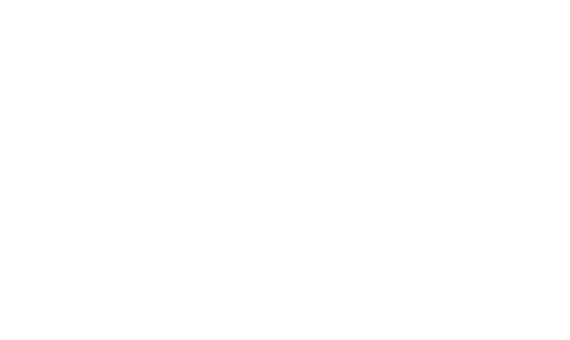

In [417]:
fname = '../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks_single/10_cone_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2/logs_episode.185_iter.0.pik'
img = visualize_trajectory(fname, gen_vid=True, plot_img=True, plot_belief=True, full_obs=True, frame_end=30)
# img = visualize_trajectory(fname, gen_vid=False, plot_img=True, plot_belief=True, full_obs=True, frame_end=29)


In [409]:
ls -lt ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks1to3

total 6
drwxrwsr-x 2 xavierpuig vision-torralba 3 Apr 12 10:03 15_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0.1v9_particles_v2_modeinfo/
drwxrwsr-x 2 xavierpuig vision-torralba 4 Apr 12 10:02 14_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0.1v9_particles_v2_modeinfo/
drwxrwsr-x 2 xavierpuig vision-torralba 4 Apr 12 09:56 13_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_modeinfo/
drwxrwsr-x 2 xavierpuig vision-torralba 4 Apr 12 09:56 11_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_modeinfo/
drwxrwsr-x 2 xavierpuig vision-torralba 4 Apr 12 09:50 4_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_modeinfo/
drwxrwsr-x 2 xavierpuig vision-torralba 4 Apr 12 09:49 1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_modeinfo/
drwxrwsr-x 2 xavierpuig vision-torralba 2 Apr  5 13:13 14_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0.1v9_particles_v2/
drwxrwsr-x 2 

100%|██████████| 1/1 [00:00<00:00, 11.18it/s]

[0]



100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

[16]



100%|██████████| 1/1 [00:00<00:00, 15.09it/s]


[18]


  0%|          | 0/1 [00:00<?, ?it/s]

[150]


  0%|          | 0/1 [00:00<?, ?it/s]

[17]
[27]


100%|██████████| 1/1 [00:00<00:00, 23.25it/s]


[10]


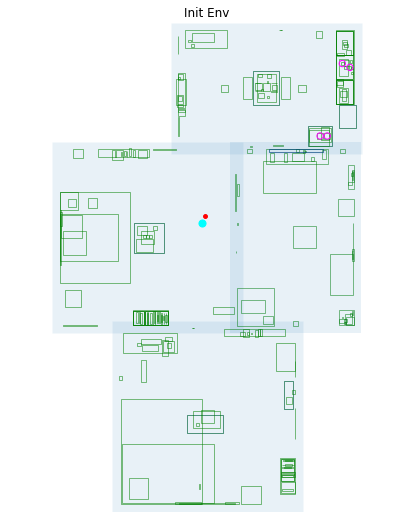

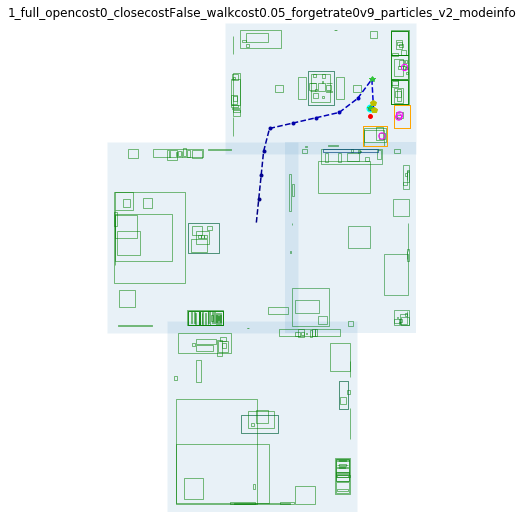

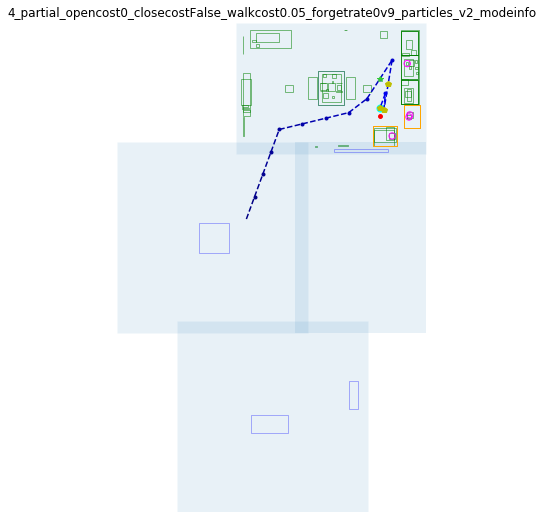

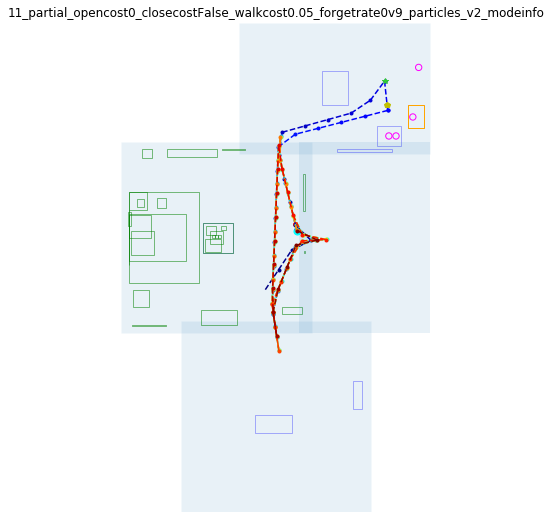

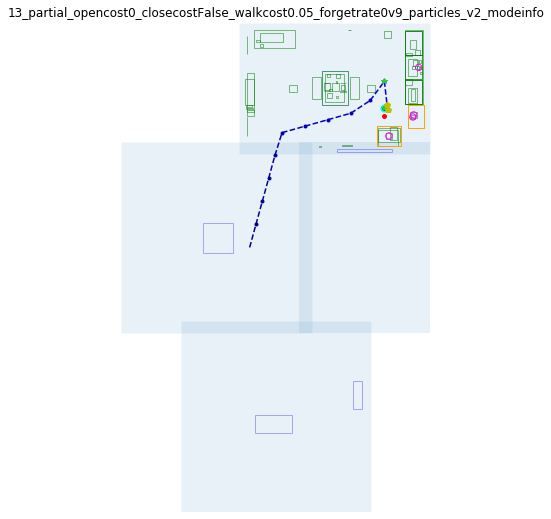

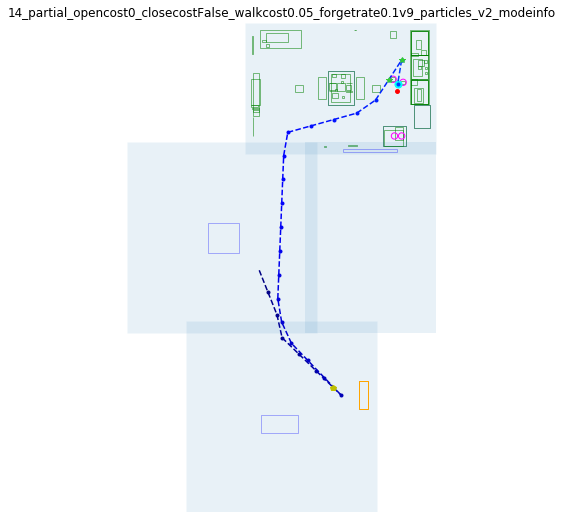

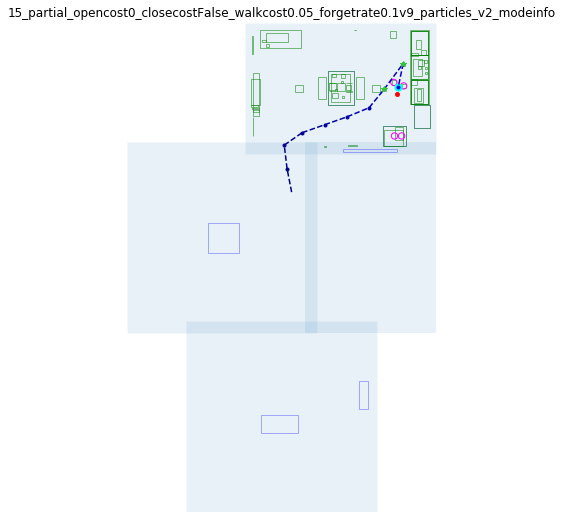

In [419]:
import glob
import os
files = glob.glob('../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks1to3/*modeinfo')
files = sorted(files, key=lambda x: int(x.split('/')[-1].split('_')[0]))
agent_name = files[0]
fn = f'{agent_name}/logs_episode.185_iter.0.pik'
img = visualize_trajectory(fn, gen_vid=False, plot_img=False, plot_belief=True, full_obs=True, frame_end=0, plot_special_actions=True)
plt.title("Init Env")
for agent_name in files:
    fname = f'{agent_name}/logs_episode.185_iter.0.pik'
    if os.path.isfile(fname):
        img = visualize_trajectory(fname, gen_vid=False, plot_img=False, plot_belief=True, full_obs=True, plot_special_actions=True)
        plt.title(fname.split('/')[-2])

In [411]:
def get_location_objects(content):
    goal_obj = [x.split('_')[1] for x, y in content['goals'][0].items() if y > 0]
    goal_name = ['{}: {}'.format(x.split('_')[1], y) for x, y in content['goals'][0].items() if y > 0]
    print(goal_name)
    graph = content['init_unity_graph']
    id2node = {node['id']: node for node in graph['nodes']}
    ids = [node['id'] for node in content['init_unity_graph']['nodes'] if node['class_name'] in goal_obj]
    locations = ['{} {} {}'.format(
        id2node[edge['from_id']]['class_name'],
        edge['relation_type'], 
        id2node[edge['to_id']]['class_name']) for edge in graph['edges'] if edge['from_id'] in ids]
    print("Locations")
    for loc in locations:
        print(loc)
    print("Beliefs")
    beliefs = content['belief'][0][0]
    print(ids)
    for idi in ids:
        
        beliefs_obj = beliefs[idi]['INSIDE']
        prob = scipy.special.softmax(beliefs_obj[1])
        names = ['None' if name is None else id2node[name]['class_name'] for name in beliefs_obj[0]]
        prob_loc = ['{}: {:.2f}'.format(names[it], prob[it]) for it in range(len(names))]
        prob_loc = ' '.join(prob_loc)
        print(id2node[idi]['class_name'], prob_loc)
        
        
# #     print(locations)
    

In [413]:
with open('{}/logs_episode.185_iter.0.pik'.format(files[2]), 'rb') as f:
    content = pkl.load(f)
print(content['action'])
get_location_objects(content)

{0: ['[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <apple> (358)', '[walktowards] <apple> (358)', '[walktowards] <apple> (358)', '[walktowards] <apple> (358)', '[walktowards] <apple> (358)', '[walktowards] <apple> (358)', '[grab] <apple> (358)', '[grab] <apple> (359)', '[walktowards] <fridge> (247)'], 1: []}
['poundcake: 1', 'apple: 1']
Locations
poundcake INSIDE kitchen
poundcake INSIDE kitchen
apple INSIDE kitchen
apple INSIDE kitchen
poundcake ON oventray
poundcake ON oventray
apple ON kitchencounter
apple ON sink
poundcake INSIDE stove
poundcake INSIDE stove
Beliefs
[356, 357, 358, 359]
poundcake None: 0.99 bathroomcabinet: 0.00 stove: 0.00 fridge: 0.00 microwave: 0.00 cabinet: 0.00
poundcake None: 0.99 bathroomcabinet: 0.00 stove: 0.00 fridge: 0.00 microwave: 0.00 cabinet: 0.00
apple None: 0.99 bathroomcabinet: 0.00 stove: 0.00 fridge: 0.00 microwave: 0.00 cabinet: 0.00
apple None:

In [389]:
content['belief'][0][0]

{30: {'INSIDE': [[None, 45, 242, 247, 251, 318],
   array([ 1.e+00, -1.e+09, -1.e+09, -1.e+09, -1.e+09, -1.e+09])],
  'ON': [[None, 111, 194, 294], array([ 1.e+00, -1.e+09, -1.e+09, -1.e+09])]},
 40: {'INSIDE': [[None, 45, 242, 247, 251, 318],
   array([ 1.e+00, -1.e+09, -1.e+09, -1.e+09, -1.e+09, -1.e+09])],
  'ON': [[None, 111, 194, 294], array([ 1.e+00, -1.e+09, -1.e+09, -1.e+09])]},
 41: {'INSIDE': [[None, 45, 242, 247, 251, 318],
   array([ 1.e+00, -1.e+09, -1.e+09, -1.e+09, -1.e+09, -1.e+09])],
  'ON': [[None, 111, 194, 294], array([ 1.e+00, -1.e+09, -1.e+09, -1.e+09])]},
 42: {'INSIDE': [[None, 45, 242, 247, 251, 318],
   array([ 1.e+00, -1.e+09, -1.e+09, -1.e+09, -1.e+09, -1.e+09])],
  'ON': [[None, 111, 194, 294], array([ 1.e+00, -1.e+09, -1.e+09, -1.e+09])]},
 50: {'INSIDE': [[None, 45, 242, 247, 251, 318],
   array([ 1.e+00, -1.e+09, -1.e+09, -1.e+09, -1.e+09, -1.e+09])],
  'ON': [[None, 111, 194, 294], array([ 1.e+00, -1.e+09, -1.e+09, -1.e+09])]},
 51: {'INSIDE': [[None, 4

In [354]:
ls ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks1to3/1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2

logs_episode.185_iter.0.pik  results_0.pik


In [243]:
rm -rf ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks_single/10_cone*

In [244]:
ls -lt ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks_single/10_cone_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2/


total 25638
drwxrwsr-x 5 xavierpuig vision-torralba        5 Apr  5 10:21 img/
-rw-rw-r-- 1 xavierpuig vision-torralba       48 Apr  5 10:20 results_0.pik
-rw-rw-r-- 1 xavierpuig vision-torralba 26920199 Apr  5 10:20 logs_episode.185_iter.1.pik
-rw-rw-r-- 1 xavierpuig vision-torralba 26918605 Apr  5 10:17 logs_episode.185_iter.0.pik


In [232]:
rm -rf /data/vision/torralba/frames/data_acquisition/SyntheticStories/agent_preferences/agent_preferences/analysis/10_cone*


In [281]:
ls -lt  ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks_single/10_cone_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2/


total 38471
-rw-rw-r-- 1 xavierpuig vision-torralba       52 Apr  5 10:24 results_0.pik
-rw-rw-r-- 1 xavierpuig vision-torralba 26915042 Apr  5 10:24 logs_episode.185_iter.2.pik
drwxrwsr-x 5 xavierpuig vision-torralba        5 Apr  5 10:21 img/
-rw-rw-r-- 1 xavierpuig vision-torralba 26920199 Apr  5 10:20 logs_episode.185_iter.1.pik
-rw-rw-r-- 1 xavierpuig vision-torralba 26918605 Apr  5 10:17 logs_episode.185_iter.0.pik


In [285]:
ls -lt  ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks1to3/13_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2

total 1841
-rw-rw-r-- 1 xavierpuig vision-torralba      42 Apr  5 13:13 results_0.pik
-rw-rw-r-- 1 xavierpuig vision-torralba 3840938 Apr  5 13:13 logs_episode.185_iter.0.pik


['../../data_scratch/large_data_toy/test_env_task_set_10_full_reduced_tasks/1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2', '../../data_scratch/large_data_toy/test_env_task_set_10_full_reduced_tasks/4_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2']
../../data_scratch/large_data_toy/test_env_task_set_10_full_reduced_tasks/1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2



100%|██████████| 38/38 [00:02<00:00, 16.16it/s]


1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_logs_episode.0_iter.0.mp4
../../data_scratch/large_data_toy/test_env_task_set_10_full_reduced_tasks/4_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2



100%|██████████| 116/116 [00:06<00:00, 18.29it/s]


4_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_logs_episode.0_iter.0.mp4


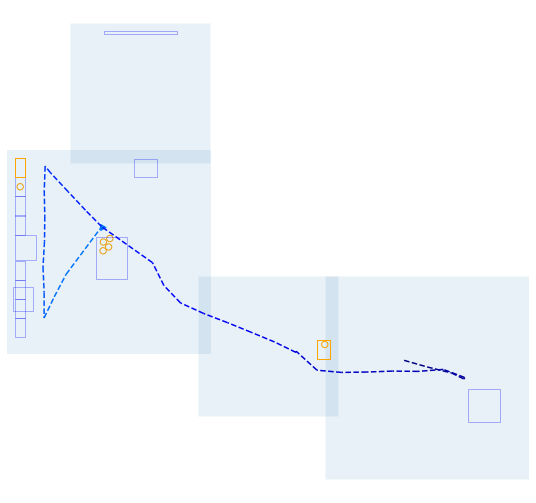

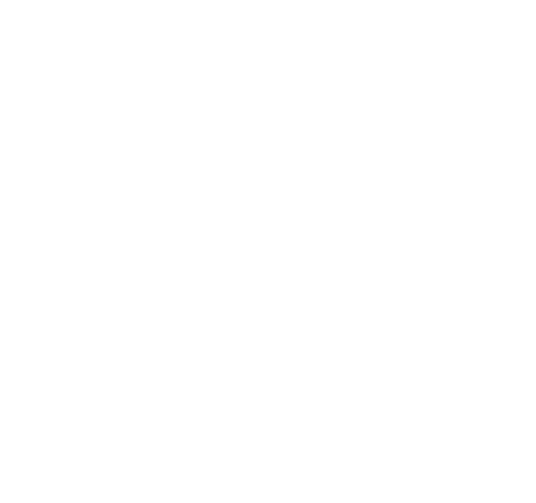

In [59]:
import glob
import os
init_path = '../../data_scratch/large_data_toy/test_env_task_set_10_full_reduced_tasks/'
files_agents = sorted(glob.glob(init_path + '*'))
print(files_agents)
for file in files_agents:
    print(file)
    fn = '/logs_episode.0_iter.0.pik'
    fname = file + fn
    if os.path.isfile(fname):
        img = visualize_trajectory(fname, gen_vid=True, plot_belief=False, full_obs=True)
#         plt.imshow(img)

In [ ]:
ls ../../data_scratch/large_data_toy/test_env_task_set_10_full_reduced_tasks_single/6_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0.2v9_particles_v2/

In [35]:
ls ../../../data_collection_wah/data_analysis/saved_data/planner/logs_agent_58_prepare_food_3/

file_0.json    file_146.json  file_192.json  file_238.json  file_59.json
file_100.json  file_147.json  file_193.json  file_239.json  file_5.json
file_101.json  file_148.json  file_194.json  file_23.json   file_60.json
file_102.json  file_149.json  file_195.json  file_240.json  file_61.json
file_103.json  file_14.json   file_196.json  file_241.json  file_62.json
file_104.json  file_150.json  file_197.json  file_242.json  file_63.json
file_105.json  file_151.json  file_198.json  file_243.json  file_64.json
file_106.json  file_152.json  file_199.json  file_244.json  file_65.json
file_107.json  file_153.json  file_19.json   file_245.json  file_66.json
file_108.json  file_154.json  file_1.json    file_246.json  file_67.json
file_109.json  file_155.json  file_200.json  file_247.json  file_68.json
file_10.json   file_156.json  file_201.json  file_248.json  file_69.json
file_110.json  file_157.json  file_202.json  file_249.json  file_6.json
file_111.json  file_158.json  file_203.json  file_24.

In [36]:
import ipdb
import json
import glob

def fill_graph(graph, id2node):
    for node in graph['nodes']:
        node['class_name'] = id2node[node['id']]['class_name']
        node['category'] = id2node[node['id']]['category']
    return graph
def generate_pkl(folder_inp, out_file='out.pkl'):
    files = glob.glob(f'{folder_inp}/file*.json')
    nsteps = len(files)
    actions = []
    graphs = []
    with open(f'{folder_inp}/init_graph.json', 'r') as f:
        content = json.load(f)
    id2node = {node['id']: node for node in content['graph']['nodes']}
    for step in range(nsteps):
#         print(step, nsteps)
        with open(f'{folder_inp}/file_{step}.json', 'r') as f:
            content = json.load(f)
        actions.append(content['instruction'])
        graphs.append(fill_graph(content['graph'], id2node))
#         ipdb.set_trace()
    print(content['predicates'])
    final_c = {
        'graph': graphs,
        'init_graph': graphs[0],
        'goals': {0: content['predicates']}
    }
    with open(out_file, 'wb') as f:
        pkl.dump(final_c, f)
file_inp = '../../../data_collection_wah/record_graph_iclr2020_backup/single_agent_maite/task_58/time.09.25.2020-20.08.42/'
file_inp = '../../../data_collection_wah/data_analysis/saved_data/planner/logs_agent_58_prepare_food_3/'
#generate_pkl(file_inp)
generate_pkl(file_inp, out_file='out_plan.pkl')

{'on_cupcake_73': 0, 'on_juice_73': 0, 'on_pancake_73': 0, 'on_poundcake_73': 1, 'on_wine_73': 0, 'on_pudding_73': 0, 'on_apple_73': 1, 'on_coffeepot_73': 0}


 60%|██████    | 150/250 [00:10<00:13,  7.33it/s]

IndexError: index 150 is out of bounds for axis 0 with size 150

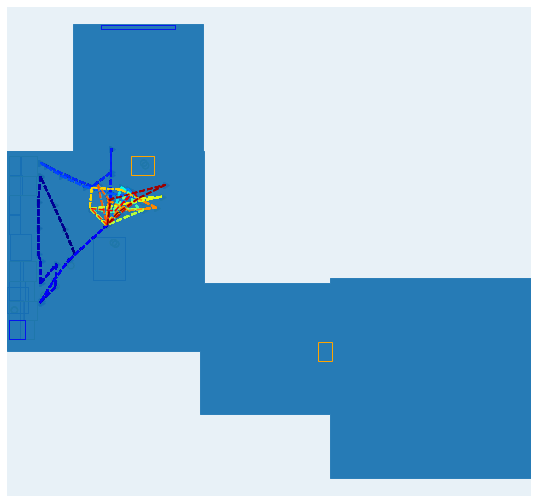

In [37]:
img = visualize_trajectory('out_plan.pkl', gen_vid=True, plot_belief=False, full_obs=True)

In [83]:
def convert_plot(out_path = 'wah_data/planner_truegoal/', file_input='../data_input/log_agent_0_read_book.pik'):

    out_path_all = out_path + file_input.split('/')[-1].replace('.pik', '')
    if not os.path.isdir(out_path_all):
        os.makedirs(out_path_all)
    with open(file_input, 'rb') as f:
            content = pkl.load(f)

#     ipdb.set_trace()

    obs0 = content['obs'][0]
#     obs1 = content['obs'][1]
    obs_char = [node for node in obs0 if node['id'] == 1][0]
#     obs_char2 = [node for node in obs1 if node['id'] == 2][0]

    with open('{}/init_graph.json'.format(out_path_all), 'w+') as f:
            graph_data = {'graph': content['init_unity_graph']}
            graph_data['graph']['nodes'].append(obs_char)
#             graph_data['graph']['nodes'].append(obs_char2)
            json.dump(graph_data, f)

    all_ids = [1, 2] + [node['id'] for node in graph_data['graph']['nodes']]
    def convert_data(node):
            # print(node)
            new_node = {name: node[name] for name in ['id', 'class_name', 'states', 'bounding_box']}
            if new_node['id'] in [1,2]:
                    new_node['bounding_box']['size'] = [0.75, 0.75, 0.75]
            return new_node


    # ipdb.set_trace()
    # First time an id is used
    first_time_id = {}
    for it in range(len(content['action'][0])):
            ids_obs = [(node['id'], node) for node in content['obs'][it]]
            ids_obs2 = [] #[(node['id'], node) for node in content['obs'][it*2 + 1]]
            for idi, node in ids_obs + ids_obs2:
                    if idi not in first_time_id:
                            first_time_id[idi] = node


    last_id = {}

    for it in range(len(content['action'][0])):
            instr = str(content['action'][0][it]) + ' | ' + str(content['action'][0][it])
#             ipdb.set_trace()
            preds = {it: prd for it, prd in content['goals'][0].items()}
            info = {
                    'instruction': [instr],
                    'predicates': preds
            }
            obs = content['obs'][it]
            obs2 = [] #content['obs'][it]
            graph = {
                    'nodes': obs + obs2,
                    'edges': []
            }
            graph['nodes'] = [convert_data(node) for node in graph['nodes']]
            
            missing_ids = set(all_ids) - set([node['id'] for node in graph['nodes']])
            for missing_id in missing_ids:
                    if missing_id in last_id:
                            graph['nodes'].append(last_id[missing_id])
                    else:
                            if missing_id in first_time_id:
                                    graph['nodes'].append(convert_data(first_time_id[missing_id]))

            # keep track of last ids
            for node in graph['nodes']:
                last_id[node['id']] = node

            info['graph'] = graph
            with open('{}/file_{}.json'.format(out_path_all, it), 'w+') as f:
                    json.dump(info, f)
# conv

In [86]:
file_inp = '../../../data_collection_wah/record_scratch/rec_good_test/multiAlice_env_task_set_20_check_neurips_test/logs_agent_58_prepare_food_0.pik'
# convert_plot(file_input=file_inp)
generate_pkl('wah_data/planner_truegoal/logs_agent_58_prepare_food_0/', out_file='out_plan_planner.pkl')
#img = visualize_trajectory(file_inp, gen_vid=True, plot_belief=False, full_obs=True)

{'on_cupcake_73': 1, 'on_juice_73': 1, 'on_pancake_73': 0, 'on_poundcake_73': 1, 'on_wine_73': 0, 'on_pudding_73': 1, 'on_apple_73': 1, 'on_coffeepot_73': 0}



100%|██████████| 122/122 [00:06<00:00, 17.52it/s]


_out_plan_planner.pkl.mp4


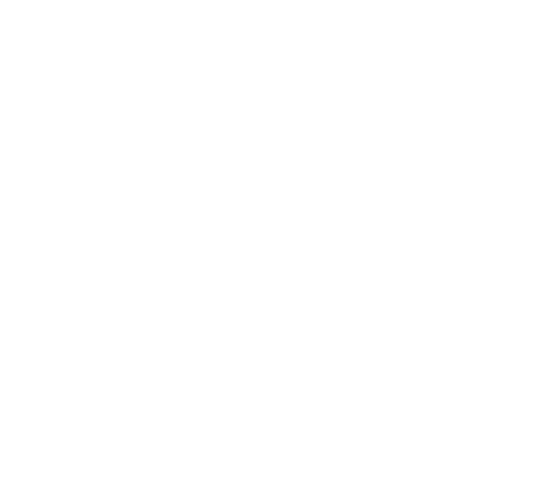

In [88]:
img = visualize_trajectory('out_plan_planner.pkl', gen_vid=True, plot_belief=False, full_obs=True)

In [266]:
with open('../dataset/train_env_task_set_20_full_reduced_tasks.pik', 'rb') as f:
    cont = pkl.load(f)

In [267]:
num_preds = []
for c in cont:
    num_preds.append(sum(c['task_goal'][0].values()))

In [268]:
from collections import Counter
Counter(num_preds)

Counter({4: 113, 2: 165, 3: 162})

In [269]:
c['task_goal']

{0: {'on_cupcake_294': 1,
  'on_juice_294': 0,
  'on_wine_294': 0,
  'on_pudding_294': 0,
  'on_apple_294': 0,
  'holds_book_1': 0,
  'sit_1_292': 1},
 1: {'on_cupcake_294': 1,
  'on_juice_294': 0,
  'on_wine_294': 0,
  'on_pudding_294': 0,
  'on_apple_294': 0,
  'holds_book_1': 0,
  'sit_1_292': 1}}